# Imports

In [5]:
%reload_ext autoreload
%autoreload 2

import torch
import datetime
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from rnn import LSTM
from decomposition import decompose
from forecast import create_rnn_forecast

In [4]:
df = pd.read_csv('daily_prices/WRB.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek
1252,2023-11-15,68.470001,69.320000,68.169998,68.540001,68.540001,1691500,2
1253,2023-11-16,69.019997,69.790001,68.860001,69.769997,69.769997,1119500,3
1254,2023-11-17,69.860001,70.470001,69.629997,70.209999,70.209999,1107600,4
1255,2023-11-20,69.910004,70.269997,69.599998,69.650002,69.650002,817100,0
1256,2023-11-21,69.949997,71.330002,69.949997,71.139999,71.139999,1216900,1


# Test dataset

In [1]:
from dataset import SP_500
from torch.utils.data import DataLoader

dataset = SP_500('daily_prices')
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=0)

In [5]:
example = next(iter(dataloader))[0]
example

tensor([[0.3926, 0.7888, 0.7735, 0.8173, 0.5108],
        [0.3453, 0.7917, 0.7753, 0.8163, 0.5061],
        [0.3736, 0.7849, 0.7665, 0.8105, 0.4665],
        ...,
        [0.3207, 0.7911, 0.7750, 0.8152, 0.5026],
        [0.4051, 0.7879, 0.7701, 0.8126, 0.5006],
        [0.3683, 0.7884, 0.7703, 0.8139, 0.4970]], dtype=torch.float64)

# Stats Models Seasonal Decompose

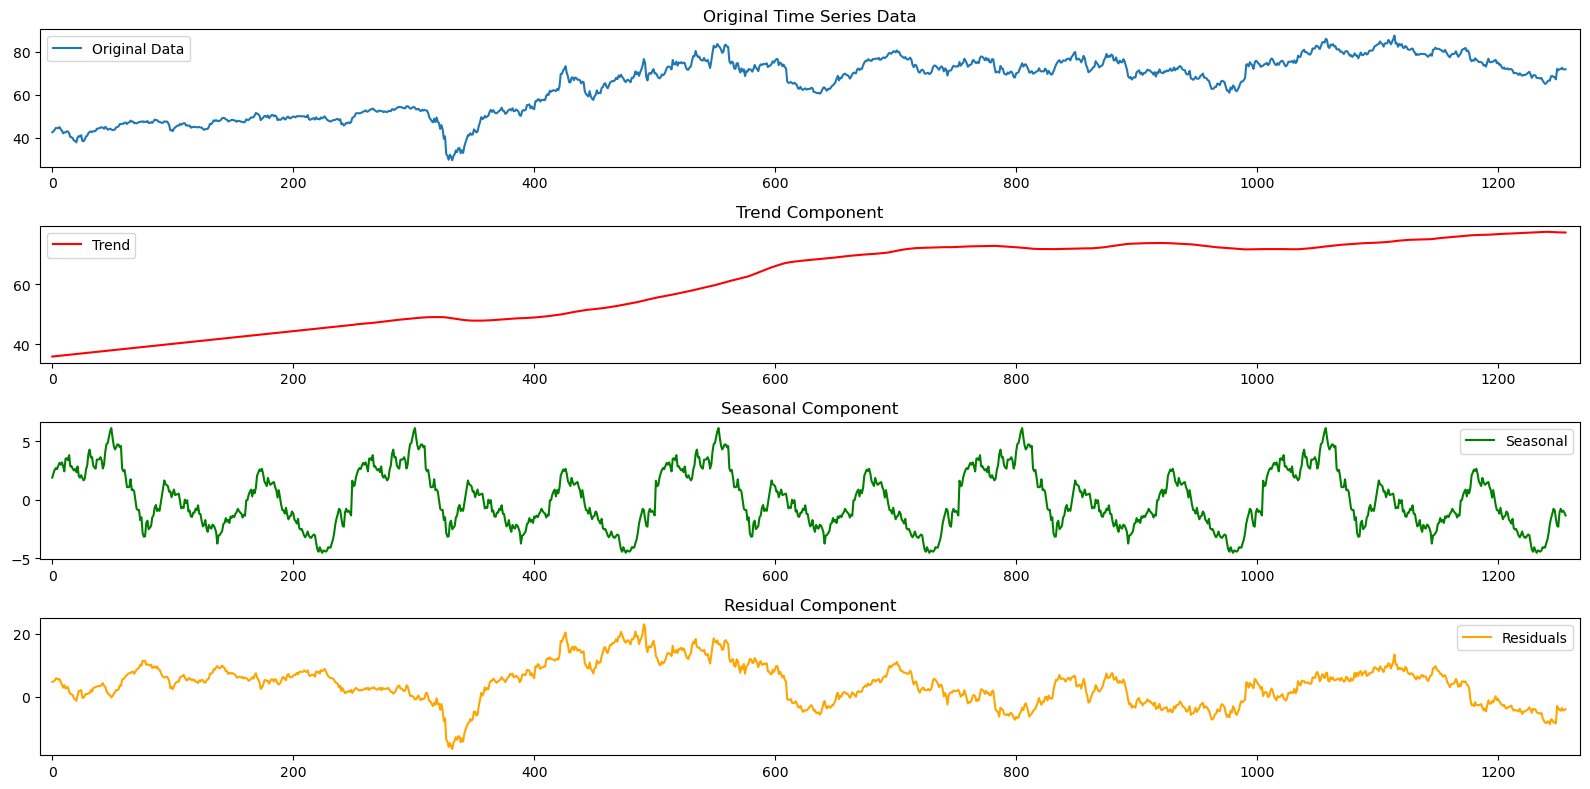

In [8]:
df = pd.read_csv('daily_prices/HOLX.csv')

# Extract the time and value columns
time_series = np.array(range(len(df['Date'])))  # Replace with your time column name
values = df['Close']                            # Replace with your value column name

# Perform seasonal decomposition
result = sm.tsa.seasonal_decompose(values, model='additive', period=252, extrapolate_trend=25, two_sided=False)

# Plot the original data, trend, seasonal, and residuals
plt.figure(figsize=(16, 8))
plt.subplot(4, 1, 1)
plt.plot(time_series, values, label='Original Data')
plt.xlim(-10,1268)
plt.legend()
plt.title('Original Time Series Data')

plt.subplot(4, 1, 2)
plt.plot(time_series, result.trend, label='Trend', color='red')
plt.xlim(-10,1268)
plt.legend()
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(time_series, result.seasonal, label='Seasonal', color='green')
plt.xlim(-10,1268)
plt.legend()
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(time_series, result.resid, label='Residuals', color='orange')
plt.xlim(-10,1268)
plt.legend()
plt.title('Residual Component')
plt.tight_layout()
plt.show()

# Test residual forecast

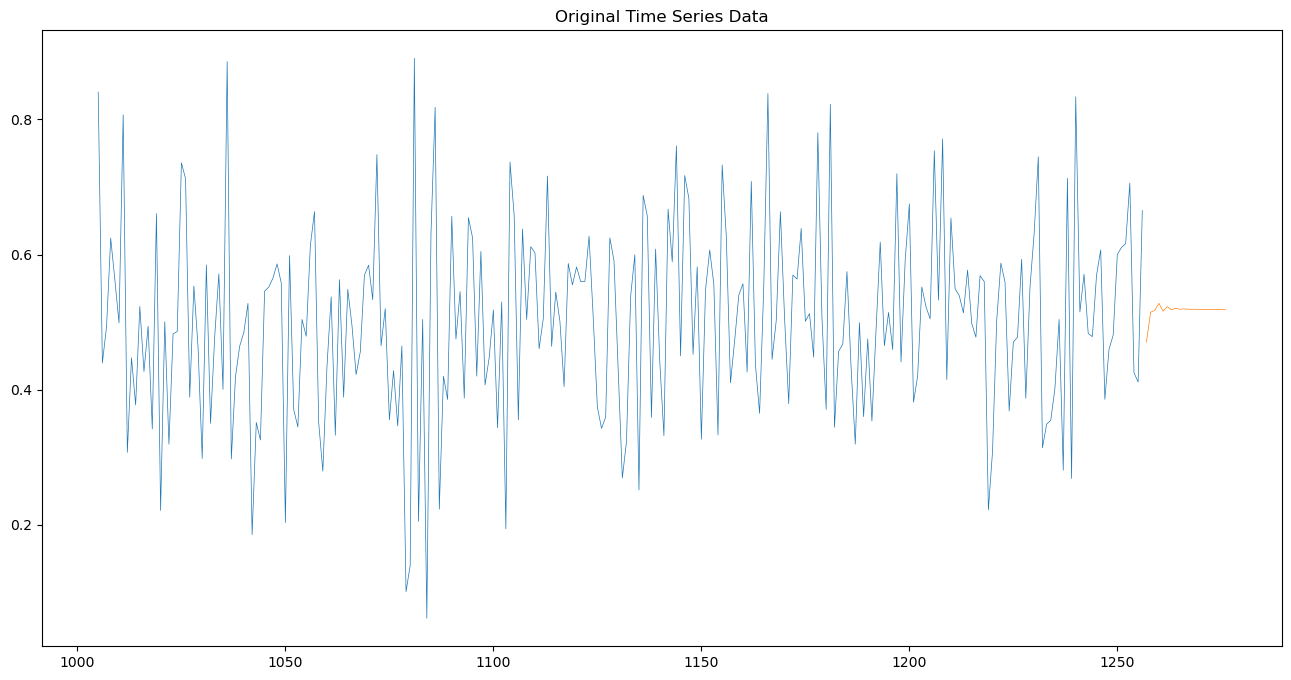

In [25]:
device = 'cpu'
horizon = 20
file = 'daily_prices/WRB.csv'

data = pd.read_csv(file).drop(columns=['Adj Close'])

# Load model
kwargs, state = torch.load('models/rnn/weights/best.pth', map_location=torch.device(device))
model = LSTM(**kwargs)
model.load_state_dict(state)
model.to(device)
model.eval()

# decompose data
decomposition = decompose(data)

# create residual forecast from model
rnn_forecast = create_rnn_forecast(torch.tensor(decomposition['input'].values).float(), model, horizon, device)
rnn_forecast.index = [decomposition['input'].index[-1]+1 + i for i in range(len(rnn_forecast.index))]

# Plot the original data, trend, seasonal, and residuals
plt.figure(figsize=(16, 8))
plt.plot(decomposition['input']['Close'][-252:], linewidth=0.5)
plt.plot(rnn_forecast['Close'], linewidth=0.5)
plt.title('Original Time Series Data')
plt.show()

In [21]:
decomposition['input'].index[-1]+1

1257

In [22]:
rnn_forecast.index = [decomposition['input'].index[-1]+1 + i for i in range(len(rnn_forecast.index))]
rnn_forecast

,Open,High,Low,Volume,Close
1257,0.546983,0.516776,0.524268,0.515703,0.470587
1258,0.509319,0.519071,0.515208,0.542870,0.514737
1259,0.509171,0.512198,0.503137,0.520492,0.517593
1260,0.517964,0.520533,0.515029,0.538121,0.527867
1261,0.506710,0.513498,0.506858,0.528343,0.516361
1262,0.513626,0.517319,0.511052,0.532782,0.523045
1263,0.509026,0.515022,0.508460,0.530260,0.518387
1264,0.511093,0.516020,0.509581,0.531276,0.520517
1265,0.509579,0.515370,0.508813,0.530660,0.519222
1266,0.509911,0.515492,0.508895,0.530693,0.519593
